### TME sur Echantillonage

## Diffusion dans les graphes 

Au cours des vingt dernières années, les réseaux sociaux sont devenus un média d’information incontournable, mettant en jeu des dynamiques complexes de communication entre utilisateurs. La modélisation de la diffusion d’information sur les réseaux constitue depuis lors un enjeu majeur, pour diverses tâches
telles que l’identification de leaders d’opinions, la prédiction ou la maximisation de l’impact d’un contenu diffusé, la détection de communautés d’opinions, ou plus généralement l’analyse des dynamiques du réseau considéré.

Le modèle proposé par (Saito et al, 2009) considère une diffusion en cascade dans laquelle l'information transite de noeuds en noeuds du réseau en suivant des relations d'influence entre les utilisateurs. Lorsqu'un utilisateur est ``infecté'' par une information, il possède une chance unique de la retransmettre à chacun de ses successeurs dans le graphe, selon une probabilité définie sur le lien correspondant. Le modèle définit en fait deux paramètres sur chaque lien $(u,v)$ du graphe:


*   $k_{u,v}$: la probabilité que l'utilisateur $u$ transmette une information diffusée à $v$
*   $r_{u,v}$: si la transmission s'effectue, l'utilisateur $v$ la reçoit au temps $t_v=t_u+\delta$, avec $\delta \sim Exp(r_{u,v})$

Pour utiliser ce modèle, on devra donc échantillonner selon la distribution exponentielle. Pour commencer, on cherche alors à écrire une méthode $exp(rate)$ qui échantillonne des variables d'une loi exponentielle selon le tableau d'intensités $rate$ passé en paramètre. Cet échantillonnage se fera par **Inverse Transform Sampling**. Pour éviter les divisions par 0, on ajoutera $1e-200$ aux intensités qui valent 0.  


In [0]:
import numpy as np
np.random.seed(0)
def exp(rate):
  #>>>>>>>>>>
  #Votre code ici
  #<<<<<<<<<<

#Test
a=exp(np.array([[1,2,3],[4,5,6]]))
for i in range(10000):
  a+=exp(np.array([[1,2,3],[4,5,6]]))
print(a/10000)

# Pour comparaison: 
a=np.random.exponential(1.0/np.array([[1,2,3],[4,5,6]]))
for i in range(10000):
  a+=np.random.exponential(1.0/np.array([[1,2,3],[4,5,6]]))
print(a/10000)


[[1.02011849 0.50670619 0.33095193]
 [0.24970305 0.20384465 0.16650975]]
[[1.00356177 0.50416273 0.34028414]
 [0.25231623 0.20024732 0.16911951]]


Soit le graphe de diffusion donné ci dessous: 

In [0]:

names={0:"Paul",1:"Jean",2:"Hector",3:"Rose",4:"Yasmine",5:"Léo",6:"Amine",7:"Mia",8:"Quentin",9:"Gaston",10:"Louise"}
k={(0,1):0.9,(1,0):0.9,(1,2):0.2,(2,3):0.5,(3,2):0.4,(2,4):0.9,(4,3):0.9,(1,3):0.5,(2,5):0.5,(5,7):0.7,(1,6):0.2,(6,7):0.1,(1,8):0.8,(8,9):0.2,(1,10):0.5,(10,9):0.9,(8,1):0.8}
r={(0,1):0.2,(1,0):3,(1,2):1,(2,3):0.2,(3,2):0.5,(2,4):10,(4,3):2,(1,3):2,(2,5):0.5,(5,7):15,(1,6):3,(6,7):4,(1,8):0.8,(8,9):0.1,(1,10):12,(10,9):1,(8,1):14}
graph=(names,k,r)


La fonction display_graph ci dessous permet de visualiser le graphe de diffusion correspondant: 

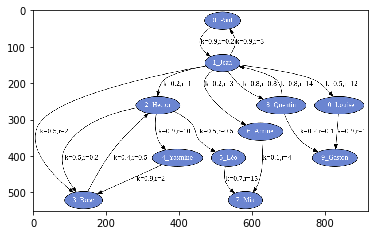

In [0]:
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

style = { "bgcolor" : "#6b85d1", "fgcolor" : "#FFFFFF" }

def display_graph ( graph_data, style, graph_name="diffusion_graph" ):
    graph = pydot.Dot( graph_name , graph_type='digraph')
    names,k,r=graph_data
    # création des noeuds du réseau
    for (i,name) in names.items():
        new_node = pydot.Node( str(i)+"_"+name,
                               style="filled",
                               fillcolor=style["bgcolor"],
                               fontcolor=style["fgcolor"] )
        graph.add_node( new_node )

    # création des arcs
    for edge,valk in k.items():
        valr=r[edge]
        n1=str(edge[0])+"_"+names[edge[0]]
        n2=str(edge[1])+"_"+names[edge[1]]
        new_edge = pydot.Edge ( n1, n2, label="k="+str(valk)+",r="+str(valr))
        graph.add_edge ( new_edge )

    # sauvegarde et affaichage
    outfile = graph_name + '.png'
    graph.write_png( outfile )
    img = mpimg.imread ( outfile )
    plt.imshow( img )
display_graph(graph,style)

On souhaite être capable d'estimer les probabilités marginales d'infection des différents utilisateurs du réseau par une information pour laquelle on connaît le début de la diffusion. 

Pour cela, on considère une liste d'infections qui correspond aux couples (utilisateur, temps d'infection) observés pour cette diffusion pendant une période de temps initial. Par exemple la liste $infections=[(1,0),(4,1)]$ 
correspond à une diffusion pour laquelle on a observé l'infection de l'utilisateur 1 au temps 0 et l'infection de l'utilisateur 4 au temps 1. 

Etant donnés les cycles possibles dans le graphe de diffusion, considérer un calcul exact des probabilités d'infection des différents utilisateurs sachant le début de la diffusion est inenvisageable : il faudrait considérer toutes les combinaisons possibles (infinies) de temps d'infection pour tous les utilisateurs non observés dans la période initiale. 

Une possibilité pour calculer ces probabilités d'infections est de travailler par échantillonnage de Monte Carlo: on réalise $n$ tirages d'infections connaissant le début de la diffusion et on recense le ratio des simulations dans lesquelles chacun des utilisateurs est infecté avant un temps $maxT$.  

L'idée est alors dans un premier temps d'écrire une méthode $simulation(graph,infections,max\_obs)$ qui, à partir d'une liste d'infections initiales et d'un temps d'observation maximal $max\_obs$, retourne les temps d'infection de l'ensemble des noeuds en fin de diffusion, sous la forme d'un tableau où chaque case $i$ contient le temps d'infection du noeud $i$. Si le noeud $i$ n'a pas été infecté ou bien si il l'a été après un temps maximal $maxT$, la case $i$ contient alors la valeur $maxT$. 


Le pseudo-code de la méthode de simulation est donné ci dessous, avec $t_i$ le temps d'infection courant du noeud $i$:
```
ti=maxT pour tout i non infecté dans la liste initiale
Tant qu'il reste des infectieux dont le temps est < maxT:
  i=Infectieux de temps d'infection minimal
  Pour tout noeud j tel que tj>ti:
    sampler x selon P(i->j|ti,tj>max_obs)
    si x==1:
       sampler delta selon Exp(rij)
       t=ti+delta
       si ti<max_obs: t+=max_obs-ti (c'est en fait une exponentielle tronquée à gauche, d'où la translation)  
       si t<tj: tj=t 
  Retrait de i de la liste des infectieux
```
où $P(i\rightarrow j|t_i,t_j>max\_obs)$ correspond à la probabilité que $i$ transmette l'information à $j$ (quel que soit le temps d'infection) sachant qu'il ne l'a pas infecté avant $max\_obs$:
$P(i\rightarrow j|t_i,t_j>max\_obs)=\begin{cases} k_{i,j} \text{ si } t_i\geq max\_obs, \\ \dfrac{k_{i,j} exp(-r_{i,j}(max\_obs-t_i))}{k_{i,j} exp(-r_{i,j}(max\_obs-t_i)) + 1 - k_{i,j} } sinon. \end{cases}$

Complétez le code de la fonction donnée ci-dessous: 


In [0]:
np.random.seed(0)
maxT=10
def simulation(graph,infections,max_obs):
    names,gk,gr=graph
    nbNodes=len(names)
    infectious=np.array([maxT]*nbNodes,dtype=float)
    ids,t=map(np.array,zip(*infections))
    ids=ids[t<=max_obs]
    t=t[t<=max_obs]
    infectious[ids]=t
    times=np.copy(infectious)
    inf=np.copy(infectious)
    while True:
      #>>>>>>>>
      #Votre code ici
      #<<<<<<<<<<<
    return(times)

print(simulation(graph,[(0,0)],0))
np.random.seed(0)
print(simulation(graph,[(0,0)],2))
np.random.seed(0)
print(simulation(graph,[(0,0),(1,1)],1))
print(simulation(graph,[(0,0),(1,1)],1))
print(simulation(graph,[(0,0),(1,1)],1))


[ 0.          1.16770561 10.         10.         10.         10.
  1.35599566 10.          1.77002662 10.         10.        ]
[ 0.          3.16770561 10.         10.         10.         10.
  3.35599566 10.          3.77002662 10.         10.        ]
[ 0.          1.         10.         10.         10.         10.
  1.18829005 10.          1.60232101 10.         10.        ]
[ 0.          1.         10.         10.         10.         10.
  1.4364346   1.73886331  1.04818107 10.         10.        ]
[ 0.          1.          3.76779418  1.17519423  3.83369212 10.
  1.15855137 10.          2.7949188  10.          1.04065132]


La méthode $getProbaMC(graph,infections,max\_obs,nbsimu)$ retourne les estimations de probabilités marginales d'infection des différents utilisateurs de $graph$, conditionnées à l'observation des infections de la liste $infections$ pendant les $max\_obs$ premiers jours de diffusion. Pour être enregistrée, une infection doit intervenir avant la seconde $maxT$. Ainsi, si la méthode retourne 0.2 pour le noeud $i$, cela indique qu'il a été infecté avec un temps $t_i \in ]max\_obs,maxT[$ dans 20% des $nbsimu$ simulations effectuées. Compléter la méthode ci dessous: 

In [0]:
np.random.seed(0)

def getProbaMC(graph,infections,max_obs,nbsimu=100000):
    names,gk,gr=graph
    nbNodes=len(names)
    rInf=np.array([0]*nbNodes)
    #>>>>>>>>>>>
    #Votre code ici
    #<<<<<<<<<<<
    return (rInf)

rInf=getProbaMC(graph,[(0,0)],0)
print(rInf)  



[1.      0.77706 0.25721 0.44541 0.23027 0.10988 0.15415 0.09081 0.58937
 0.36159 0.38881]


Cette méthode permet de bonnes estimations (malgré une certaine variance) lorsque l'on n'a pas d'observations autres que le vecteur d'infections initiales (i.e., on estime des probabilités de la forme: $P(t_i < maxT|\{t_j\leq max\_obs\})$). Par contre, si l'on souhaite obtenir des probabilités d'infection du type $P(t_i < maxT|\{t_j\leq max\_obs\}, \{t_j, j \in {\cal O}\})$, c'est à dire conditionnées à des observations supplémentaires pour un sous-ensembles de noeuds ${\cal O}$ (avec $t_j > max\_obs$ pour tout noeud de ${\cal O}$), l'utilisation de la méthode de MonteCarlo précédente est impossible. Cela impliquerait de filtrer les simulations obtenues selon qu'elles remplissent les conditions sur les noeuds de ${\cal O}$, ce qui nous amènerait à toutes les écarter sachant que l'on travaille avec des temps continus. 

Pour estimer ce genre de probabilité conditionnelle, nous allons nous appuyer sur des méthodes de type MCMC, notamment la méthode de Gibbs Sampling. Cette méthode est utile pour simuler selon une loi jointe, lorsqu'il est plus simple d'échantillonner de chaque variable conditionnellement à toutes les autres plutôt que directement de cette loi jointe. L'algorithme est donné par: 


1.   Tirage d'un vecteur de valeurs initiales pour toutes les variables $X_i$
2.   Pour toutes les variable $X_i$ choisies dans un ordre aléatoire, échantillonnage d'une nouvelle valeur: $X_i \sim p(x_i\mid x_1,\dots,x_{i-1},x_{i+1},\dots,x_n)$
3.   Recommencer en 2 tant qu'on souhaite encore des échantillons

Notons qu'il est souvent utile d'exploiter la relation suivante, qui indique que pour échantillonner de la loi conditionnelle, il suffit d'échantillonner chaque variable proportionnellement à la loi jointe, avec toutes les autres variables fixées: 
$$p(x_j\mid x_1,\dots,x_{j-1},x_{j+1},\dots,x_n) = \frac{p(x_1,\dots,x_n)}{p(x_1,\dots,x_{j-1},x_{j+1},\dots,x_n)} \propto p(x_1,\dots,x_n)$$

Après une période dite de $Burnin$ d'un nombre d'époques à définir, l'algorithme émet des échantillons qui suivent la loi jointe connaissant les observations. Lorsque l'objectif est d'estimer des probabilités marginales, on fait alors tourner cet algorithme pendant une certain nombre d'époques après la période de $Burnin$, au cours desquelles on recence les différentes affectations de chacune des variables étudiées. 

Pour mettre en oeuvre cet algorithme, nous aurons aurons besoin d'avoir accès rapidement aux prédecesseurs et successeurs dans le graphe. La méthode ci-dessous retourne un couple de dictionnaires à partir du graphe: 
 

*   $preds[i]$  contient la liste des prédécesseurs du  noeud $i$, sous la forme d'une liste de triplets $(j,k_{j,i},r_{j,i})$ pour tous les $j$ précédant $i$ dans le graphe.    
*   $succs[i]$  contient la liste des successeurs du  noeud $i$, sous la forme d'une liste de triplets $(j,k_{i,j},r_{i,j})$ pour tous les $j$ pointés par $i$ dans le graphe.





In [0]:
def getPredsSuccs(graph):
    names,gk,gr=graph
    nbNodes=len(names)
    preds={}
    succs={}
    for (a,b),v in gk.items():
      s=succs.get(a,[])
      s.append((b,v,gr[(a,b)]))
      succs[a]=s
      p=preds.get(b,[])
      p.append((a,v,gr[(a,b)]))
      preds[b]=p
    return (preds,succs)
preds,succs=getPredsSuccs(graph)
print("preds=",preds)
print("succs=",succs)

preds= {1: [(0, 0.9, 0.2), (8, 0.8, 14)], 0: [(1, 0.9, 3)], 2: [(1, 0.2, 1), (3, 0.4, 0.5)], 3: [(2, 0.5, 0.2), (4, 0.9, 2), (1, 0.5, 2)], 4: [(2, 0.9, 10)], 5: [(2, 0.5, 0.5)], 7: [(5, 0.7, 15), (6, 0.1, 4)], 6: [(1, 0.2, 3)], 8: [(1, 0.8, 0.8)], 9: [(8, 0.2, 0.1), (10, 0.9, 1)], 10: [(1, 0.5, 12)]}
succs= {0: [(1, 0.9, 0.2)], 1: [(0, 0.9, 3), (2, 0.2, 1), (3, 0.5, 2), (6, 0.2, 3), (8, 0.8, 0.8), (10, 0.5, 12)], 2: [(3, 0.5, 0.2), (4, 0.9, 10), (5, 0.5, 0.5)], 3: [(2, 0.4, 0.5)], 4: [(3, 0.9, 2)], 5: [(7, 0.7, 15)], 6: [(7, 0.1, 4)], 8: [(9, 0.2, 0.1), (1, 0.8, 14)], 10: [(9, 0.9, 1)]}


Pour calculer les probabilités conditionnelles, il faut prendre en compte les quantités suivantes: 


*   Probabilité pour $j$ d'être infecté par $i$ au temps $t_j$ connaissant $t_i < t_j$:  
$$\alpha_{i,j}=k_{i,j}r_{i,j} exp(-r_{i,j}(t_j-t_i))$$
*   Probabilité pour $j$ de ne pas être infecté par $i$ jusqu'au temps $t$:
$$\beta_{i,j}=k_{i,j} exp(-r_{i,j}(t_j-t_i)) + 1 - k_{i,j}$$
*   Probabilité pour $j$ d'être infecté au temps $t_j$ connaissant les prédecesseurs infectés avant $t_j$:
$$h_{j}=\prod_{i \in preds[j], t_i<t_j} \beta_{i,j} \sum_{i \in preds[i], t_i<t_j} \alpha_{i,j} / \beta_{i,j}$$
*   Probabilité pour $j$ de ne pas être infecté avant $t_j=maxT$ connsaissant ses prédecesseurs infectés:
$$g_{j}=\prod_{i \in preds[j], t_i<t_j} \left(k_{i,j} exp(-r_{i,j}(maxT-t_i)) + 1 - k_{i,j}\right)=\prod_{i \in preds[j], t_i<t_j} \beta_{i,j}$$

A noter que pour tout $i$ tel que $t_i< max\_obs$, on prend $\frac{\alpha_{i,j}}{k_{i,j} exp(-r_{i,j}(max\_obs-t_i))}$ et $\frac{\beta_{i,j}}{k_{i,j} exp(-r_{i,j}(max\_obs-t_i))}$  dans les définitions de $h_j$ et $g_j$ (donc dans le calcul de la variable $b$ dans la méthode ci-dessous). 


Dans la méthode $computeab(v, times, preds, max\_obs)$, on prépare le calcul et les mises à jour de ces quantités. La méthode calcule, pour un noeud $v$ selon les temps d'infection courants donnés dans $times$, deux quantités $a$ et $b$: 
*   $a= max(1e^{-20}, \sum_{i \in preds[v], t_i<t_v} \alpha_{i,v} / \beta_{i,v})$ si $t_v< maxT$ et $a=1$ sinon. 

*   $b=\sum_{i \in preds[v], t_i<t_v} \log \beta_{i,v}$.

Pour les noeuds $i$ tels que $t_i< max\_obs$, $a=1$ et $b=0$. 

Compléter la méthode $computeab$ donnée ci-dessous:   



In [0]:
eps=1e-20

def computeab(v, times, preds, max_obs):
  preds=preds.get(v,[])
  t=times[v]
  if t<=max_obs:
    return (1,0)
  a=eps
  b=0
  if len(preds)>0:
    #>>>>>>>>>>>>>
    #Votre code ici
    #<<<<<<<<<<<<
  return (a,b)

nbNodes=len(graph[0])
times=np.array([maxT]*nbNodes,dtype=float)
times[0]=0
times[1]=1
times[2]=4
#times[3]=10


print(computeab(0,times,preds,max_obs=0))
print(computeab(0,times,preds,max_obs=2))
print(computeab(1,times,preds,max_obs=0))
print(computeab(1,times,preds,max_obs=2))
print(computeab(2,times,preds,max_obs=0))
print(computeab(2,times,preds,max_obs=2))
print(computeab(3,times,preds,max_obs=0))
print(computeab(3,times,preds,max_obs=2))





(1, 0)
(1, 0)
(0.17610107365772135, -0.17810126145719926)
(1, 0)
(0.012293749653343877, -0.2107736084094422)
(0.012293749653343877, -0.07561333357263264)
(1.0, -1.12301187855188)
(1.0, -0.5567927090349072)


La méthode $computell$ calcule la log-vraisemblance d'une diffusion (représentée par le tableau times), en appelant la méthode computeab sur l'ensemble des noeuds du réseau. Elle retourne un triplet (log-likelihood, sa, sb), avec $sa$ et $sb$ les tables des valeurs $a$ et $b$ pour tous les noeuds.   

In [0]:
def computell(times,preds,max_obs):
  #>>>>>>
  #Votre code ici
  #<<<<<

ll,sa,sb=computell(times,preds,max_obs=0)
print("ll=",ll)
print(times)
print("like_indiv=",np.exp(np.log(sa)+sb))


ll= -13.117139892397578
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
like_indiv= [1.         0.14737154 0.00995741 0.32529856 0.1        0.52489353
 0.8        1.         0.20059727 1.         0.5       ]


Afin de préparer les mises à jour lors des affectations successives des variables du Gibbs Sampling, on propose de définir une méthode $removeV(v,times,succs,sa,sb)$ qui retire temporairement du réseau un noeud $v$, en passant son temps d'infection à -1 dans times et en retirant sa contribution aux valeurs a et b (contenues dans sa et sb) de tous ses successeurs $j$ tels que $t_j > t_v$ (y compris donc les non infectés qui sont à $t_j=maxT$). 

In [0]:
def removeV(v,times,succs,sa,sb):
  succs=succs.get(v,[])
  t=times[v]
  if t<0:
    return 
  times[v]=-1
  sa[v]=1.0
  sb[v]=0.0
  if len(succs)>0:
    c,k,r=map(np.array,zip(*succs))
    tp=times[c]
    which=(tp>t)

    tp=tp[which]
    dt=tp-t
    k=k[which]
    r=r[which]
    c=c[which]
    rt = -r*dt
    b1=k*np.exp(rt)
    b=b1+1.0-k
    
    a=r*b1
    a=a/b
    b=np.log(b)
    
    sa[c]=sa[c]-np.where(tp<maxT,a,0.0)
    sa[c]=np.where(sa[c]>eps,sa[c],eps)
    sb[c]=sb[c]-b
    sb[c]=np.where(sb[c]>0,0,sb[c])


#Test
print("sa=",sa)
print("sb=",sb)

nsa=np.copy(sa)
nsb=np.copy(sb)
ntimes=np.copy(times)
removeV(3,ntimes,succs,nsa,nsb)
print("diffa=",nsa-sa)
print("diffb=",nsb-sb)

nsa=np.copy(sa)
nsb=np.copy(sb)
ntimes=np.copy(times)
removeV(1,ntimes,succs,nsa,nsb)
print("diffa=",nsa-sa)
print("diffb=",nsb-sb)


sa= [1.         0.17610107 0.01229375 1.         1.         1.
 1.         1.         1.         1.         1.        ]
sb= [ 0.         -0.17810126 -0.21077361 -1.12301188 -2.30258509 -0.64455983
 -0.22314355  0.         -1.60645602  0.         -0.69314718]
diffa= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
diffb= [0.         0.         0.         1.12301188 0.         0.
 0.         0.         0.         0.         0.        ]
diffa= [ 0.          0.82389893 -0.01229375  0.          0.          0.
  0.          0.          0.          0.          0.        ]
diffb= [0.         0.17810126 0.21077361 0.69314717 0.         0.
 0.22314355 0.         1.60645602 0.         0.69314718]


La méthode addVatT fait l'inverse: elle rajoute un noeud qui était retiré du réseau, avec un temps $newt$. Il faut alors mettre à jour les valeurs a et b (dans sa et sb) de tous les successeurs de $v$ tels que $t_j > newt$ et calculer les valeurs a et b du noeud v. 

Compléter le code ci-dessous: 

In [0]:
def addVatT(v,times,newt,preds,succs,sa,sb,max_obs):
  t=times[v]
  if t>=0:
    raise Error("v  must have been removed before")
  
  #>>>>>>>>>>>>
  #Votre code ici
  #<<<<<<<<<<<<<<<<<<<

# Tests: 
   
nsa=np.copy(sa)
nsb=np.copy(sb)
c,_,_=map(np.array,zip(*succs[1]))
c=np.append(c,1)
ll=np.sum((np.log(nsa)+nsb)[c])
removeV(1,times,succs,nsa,nsb)
addVatT(1,times,2,preds,succs,nsa,nsb,max_obs=0)
ll2=np.sum((np.log(nsa)+nsb)[c])
removeV(1,times,succs,nsa,nsb)
addVatT(1,times,1,preds,succs,nsa,nsb,max_obs=0)
ll3=np.sum((np.log(nsa)+nsb)[c])
llall=np.sum(np.log(nsa)+nsb)
print(np.exp(ll),np.exp(ll2),np.exp(ll3),llall)

c,_,_=map(np.array,zip(*succs[0]))
c=np.append(c,0)
ll=np.sum((np.log(nsa)+nsb)[c])
removeV(0,times,succs,nsa,nsb)
addVatT(0,times,maxT,preds,succs,nsa,nsb,max_obs=0)
ll2=np.sum((np.log(nsa)+nsb)[c])
removeV(0,times,succs,nsa,nsb)
addVatT(0,times,0,preds,succs,nsa,nsb,max_obs=0)
ll3=np.sum((np.log(nsa)+nsb)[c])
llall=np.sum(np.log(nsa)+nsb)
print(np.exp(ll),np.exp(ll2),np.exp(ll3),llall)

c,_,_=map(np.array,zip(*succs[5]))
c=np.append(c,5)
ll=np.sum((np.log(nsa)+nsb)[c])
removeV(5,times,succs,nsa,nsb)
addVatT(5,times,1,preds,succs,nsa,nsb,max_obs=0)
ll2=np.sum((np.log(nsa)+nsb)[c])
removeV(5,times,succs,nsa,nsb)
addVatT(5,times,maxT,preds,succs,nsa,nsb,max_obs=0)
ll3=np.sum((np.log(nsa)+nsb)[c])
llall=np.sum(np.log(nsa)+nsb)
print(np.exp(ll),np.exp(ll2),np.exp(ll3),llall)



3.830251606174211e-05 8.555487921315824e-05 3.830251606174211e-05 -13.117139892397578
0.14737153555403676 1.0000000000169125e-21 0.14737153555403676 -13.117139892397578
0.5248935341839319 2.999999999999998e-21 0.5248935341839319 -13.117139892397578


Pour échantillonner pour une variable $i$, il faudra être à même de comparer les vraisemblances selon les différentes affectations. Cela implique de calculer la somme de toutes ces vraisemblances. Mais pour réaliser cette somme, il faudrait que nous sortions de la représentation logarithmique: $\sum_{t_i} exp(log(p(t_1,\dots,t_i,\dots,t_n))$. Si on le fait de cette manière, on risque d'avoir des arrondis à 0 presque partout. Une possibilité (log-sum-exp trick) est d'exploiter la relation suivante:  

$$\log\sum_i x_i = x^* + \log\left( \exp(x_1-x^*)+ \cdots + \exp(x_n-x^*) \right)$$
avec $x^* = \max{\{x_1, \dots, x_n\}}$

Compléter la méthode logsumexp suivante, qui réalise cette somme en évitant les problèmes numériques: 


In [0]:
def logsumexp(x,axis=-1):
  #>>>>>>>>>>
  #Votre code ici
  #<<<<<<<<<<
  return x
  

#Test: 
x=np.array([[0.001,0.02,0.008],[0.1,0.01,0.4]])
r=np.log(np.sum(x,-1))
x=np.log(x)
r2=logsumexp(x)
print(r2,r)



[-3.54045945 -0.67334455] [-3.54045945 -0.67334455]


On souhaite maintenant mettre en place une méthode $sampleV(v,times,newt,preds,succs,sa,sb,max\_obs,k,k2)$ qui sample un nouveau temps d'infection pour le noeud $v$, connaissant les temps de tous les autres noeuds dans $times$ (ainsi que leurs valeurs $a$ et $b$ correspondantes contenues dans sa et sb). Puisque le domaine de support de $t_v$ est continu, on doit faire quelques approximations en se basant sur une discrétisation des valeurs possibles:


1.   On échantillonne $k$ points $d_1,\dots,d_k$ entre $max\_obs$ et $maxT$ de manière uniforme, que l'on ordonne de manière croissante. On ajoute $t_v$ à cet ensemble de points pour gagner en stabilité (inséré dans la liste de manière à conserver l'ordre croissant).   
2.   On considère chaque point $d_i$ comme le centre d'un bin $[(d_i+d_{i-1})/2,(d_i+d_{i+1})/2]$. Pour $d_1$ on prend $[max\_obs,(d_i+d_{i+1})/2]$ et pour $d_k$ on prend   $[(d_i+d_{i-1})/2,maxT]$. On fait l'hypothèse que la densité de probabilité est constante sur l'ensemble du bin, que l'on évalue en son centre.   La probabilité que l'on échantillonne dans le bin $i$ est alors égale à: $\frac{z_i \times l_i}{\sum_j z_j \times l_j + p_{maxT}}$, avec $z_i$ la densité calculée en $d_i$, $l_i$ la taille du bin $i$ et $p_{maxT}$ la probabilité calculée pour $maxT$ (i.e., la probabilité que $v$ ne soit pas infecté dans la diffusion)
3.  Si l'indice $i$ samplé de manière proportionnelle aux probabilités calculées à l'étape précédente n'est pas celui de $maxT$, $v$ est alors infecté à un temps inclus dans l'intervale du bin correspondant. Il s'agit alors de re-échantillonner $k2$ points uniformément dans ce bin et de calculer les densités en ces points (pour gagner en stabilité on ajoute le centre du bin $d_i$). Le nouveau temps de $v$ est alors échantillonné proportionnellement à ces densités.

Compléter le code ci-dessous:





In [0]:
np.random.seed(0)


  
def sampleV(v,times,preds,succs,sa,sb,max_obs,k,k2):
  #>>>>>>>>>>>>>>>>>>>>>>>>>>
  #Votre code ici
  #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
  
  
print(times)
sampleV(5,times,preds,succs,sa,sb,0,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,0,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,0,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,0,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,0,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,0,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,0,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,0,10,10)
print(times)


[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.          1.          4.         10.         10.          4.20931617
 10.         10.         10.         10.         10.        ]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]


Compléter la méthode de Gibbs Sampling $gb$ ci-dessous: 

In [0]:

np.random.seed(1)
def gb(graph,infections,max_obs,burnin=1000,nbEpochs=10000,k=100,k2=50,freqRecord=1):
   #>>>>>>>>>>>>>>>>>>>>>>>
   #Votre code ici
   #>>>>>>>>>>>>>>>>>>>>>>>>>>
   return rate

rate=gb(graph,[(0,0)],0)
print(rate)

# Partie optionnelle

L'algorithme de Metropolis-Hasting est une autre méthode de type MCMC qui utilise une distribution d'échantillonnage pour se déplacer dans l'espace des points considérés. Il s'agit de définir une distribution $q(y_{t+1}|x_t)$ de laquelle on sait générer un déplacement. L'algorithme procéde alors de la manière suivante: 


1.   Générer $y_{t+1}$ selon $q(y_{t+1}|x_t)$ 
2.   Calculer la probabilité d’acceptation $\alpha(x_t,y_{t+1})=\min\left\{\frac{\pi(y_{t+1})q(x_t,y_{t+1})}{\pi(x_t)q(y_{t+1},x_t)},1\right\} \,\!, \text{ avec } \pi(x_t) \text{ la densité de probabilité de } x_t$
3.   Prendre $x_{t+1}=\begin{cases} y_{t+1}, & \text{avec probabilité}\,\,\alpha \\ x_t, & \text{avec probabilité}\,\,1-\alpha \end{cases}$



Dans notre cas, on propose de travailler avec des déplacements correspondants à des permutations d'un temps d'infection à chaque itération, comme dans le cadre du Gibbs Sampling. A chaque étape on choisit donc une variable à modifier, on choisit un nouveau temps pour cette variable et on calcule la densité correspondante. La probabilité d'acceptation est ensuite calculée selon cette densité et la probabilité du déplacement selon la distribution $q$ qui a servi à générer le nouveau temps d'infection. On se propose de choisir $maxT$ avec une probabilité de 0.1. La probabilité $q(t_v|t)$ pour $t< maxT$ est alors égale  à  $0.9\times \frac{1}{maxT-max\_obs}$.

Implémenter l'approche d'échantillonnage par Metropolis-Hasting pour notre problème d'estimation de probabilités marginales d'infection. 

In [0]:
#Votre code ici